In [2]:
#importando las librerias necesarias
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import os #procesar datasets
from time import perf_counter
import cv2
import tensorflow as tf

In [3]:
dataFrame = {
    'image' :[],
    'box'   :[],
} # dataframe es una estructura de datos con dos dimensiones, en este caso image y box, image es la imagen sin ninguna modificación, y el box es la imagen con el cuadro dibujado.

In [4]:
#esta función compuesta me permite bibujar la caja alrededor de la placa 

def Reader(path, annotPath, size = 256, isPlot = False, showTime = False):

  start = perf_counter() # iniciando contador 
  img = plt.imread(path) # lee una imagen dentro de un archivo en un array
  img = np.array (img[:, :, 0:3]) 

  if isPlot:
    plt.subplot(1, 2, 1) # (filas, columnas, index of subplot)
    plt.imshow(img) # mostrar datos como imagen

#analizando html
  with open(annotPath, 'r') as f: #r es abrir para leer, hay más, como w. es es abrir para escribir
    data = f.read() #leer

  Bs = BeautifulSoup(data, "xml") #
  xMax = int (Bs.find('xmax').text) # casteo
  xMin = int (Bs.find('xmin').text)
  yMax = int (Bs.find('ymax').text)
  yMin = int (Bs.find('ymin').text)

#Almacenar los datos
  dataFrame['image'].append ( cv2.resize(img, (size, size))) #almacenar los datos en el dataFrame de imagen, es la imagen original.
#dibujar la caja de color 
  imgBoxed = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (0 ,255, 0),2) # verde, aquí se dibuja la cajita con las coordenadas x minimo, y minimo, x maximo y y maximo.

#almacenar datos dentro de DataFrame
  x = yMin
  while x < yMax:
    y = xMin
    while y < xMax:
      img[x, y, 1] = 1
      y += 1
    x += 1

  dataFrame['box'].append (cv2.resize(imgBoxed, (size, size))) #almacenar los datos en el dataframe box, es la imagen con la cajita dibujada.

  if isPlot:
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.resize(imgBoxed, (size, size)))

  if showTime:
    return perf_counter() - start
  

In [5]:
# definir iterador
def Iterator(imageDir, annotDir):
  start = perf_counter() # inicia el contador.
  imageNames = os.listdir(imageDir)

  for mem in imageNames:
    path = imageDir + '/' + mem 
    annotPath = annotDir + '/' + mem.split('.')[0] + '.xml'
    Reader(path,annotPath)

  return perf_counter() - start 

In [6]:
from google.colab import drive # acceso a google colab
drive.mount("/gdrive")

Mounted at /gdrive


In [7]:
Iterator('/gdrive/My Drive/Colab Notebooks/archive/Base de datos Placas vehículares','/gdrive/My Drive/Colab Notebooks/archive/annotations') # aquí incluimos el dataset de las imagenes y de las coordenadas.

445.76621476800005

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


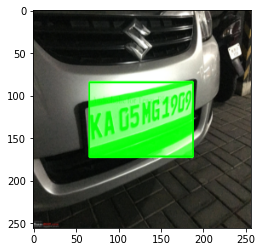

In [22]:
plt.imshow(dataFrame['box'][1])

In [9]:
# definir el modelo del codificador automático

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
  #primera convolución
  x = tf.keras.layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                             kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

  if doBatchNorm:
    x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Activation('relu')(x)

  #segunda convolución
  x = tf.keras.layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                             kernel_initializer = 'he_normal', padding = 'same') (x)

  if doBatchNorm:
    x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Activation('relu')(x)
  return x

In [10]:
# definiendo UNET
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
#Definiendo ruta del codificador
  c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
  p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
  p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
  c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
  p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
  p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
  c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
  p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
  p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
  c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
  p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
  p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
  c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
#definiendo ruta del decodificador
  u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  u6 = tf.keras.layers.Dropout(droupouts)(u6)
  c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
  u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = tf.keras.layers.Dropout(droupouts)(u7)
  c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
  u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = tf.keras.layers.Dropout(droupouts)(u8)
  c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
  u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1])
  u9 = tf.keras.layers.Dropout(droupouts)(u9)
  c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
  output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'softmax')(c9)
  model = tf.keras.Model(inputs = [inputImage], outputs = [output])
  return model


In [11]:
# modelo de instancia
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [12]:
np.array(dataFrame['box'])

array([[[[0.21317473, 0.20790602, 0.2058468 ],
         [0.7412718 , 0.7668223 , 0.749226  ],
         [0.7922346 , 0.803159  , 0.86573154],
         ...,
         [0.26619473, 0.2802499 , 0.3004866 ],
         [0.37978107, 0.3834124 , 0.38744378],
         [0.3225458 , 0.23465663, 0.2340429 ]],

        [[0.18352225, 0.189267  , 0.18683961],
         [0.6565856 , 0.6859256 , 0.6663425 ],
         [0.7886879 , 0.8009361 , 0.86461097],
         ...,
         [0.2900788 , 0.30298835, 0.29334155],
         [0.35651636, 0.35777718, 0.3507103 ],
         [0.3337903 , 0.27691254, 0.27712774]],

        [[0.16680218, 0.17083943, 0.1665399 ],
         [0.49162996, 0.4617683 , 0.44068143],
         [0.7003356 , 0.5814976 , 0.66751415],
         ...,
         [0.39938855, 0.39451772, 0.40027633],
         [0.47531688, 0.46867996, 0.47387832],
         [0.3429532 , 0.30518845, 0.3151447 ]],

        ...,

        [[0.08198464, 0.08820742, 0.08684576],
         [0.07894128, 0.0778079 , 0.07754886]

In [13]:
retVal = myTransformer.fit(np.array(dataFrame['image']), np.array(dataFrame['box']), epochs = 30, verbose = 1)

Epoch 1/30
14/14 [==============================] - 26s 956ms/step - loss: 2.5495 - accuracy: 0.3392
Epoch 2/30
14/14 [==============================] - 10s 722ms/step - loss: 2.3110 - accuracy: 0.3920
Epoch 3/30
14/14 [==============================] - 10s 717ms/step - loss: 2.0909 - accuracy: 0.3903
Epoch 4/30
14/14 [==============================] - 10s 717ms/step - loss: 2.1035 - accuracy: 0.3987
Epoch 5/30
14/14 [==============================] - 10s 717ms/step - loss: 1.9425 - accuracy: 0.3911
Epoch 6/30
14/14 [==============================] - 10s 721ms/step - loss: 1.9643 - accuracy: 0.3736
Epoch 7/30
14/14 [==============================] - 10s 717ms/step - loss: 1.9130 - accuracy: 0.3832
Epoch 8/30
14/14 [==============================] - 10s 716ms/step - loss: 1.9531 - accuracy: 0.3767
Epoch 9/30
14/14 [==============================] - 10s 716ms/step - loss: 1.8510 - accuracy: 0.3762
Epoch 10/30
14/14 [==============================] - 10s 718ms/step - loss: 1.8543 - accura

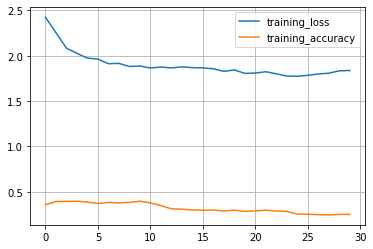

In [14]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [15]:

## función para obtener 16 predicciones
def predict16 (valMap, model, shape = 256):
    ## obtener y procesar datos
    img = valMap['image']
    #img = img_new
    mask = valMap['box']
    mask = mask[0:17]
    
    imgProc = img [0:17]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('original Image')
    
    ## Paso de nitidez de la imagen
    ## es un filtro de afilado
    filter = np.array([[-1, -1, -1], [-1, 8.99, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,3,2)
    plt.imshow(imgSharpen)
    plt.title('Predicted Box position')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual box Position')

In [16]:
sixteenPrediction, actuals, masks = predict16(dataFrame, myTransformer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


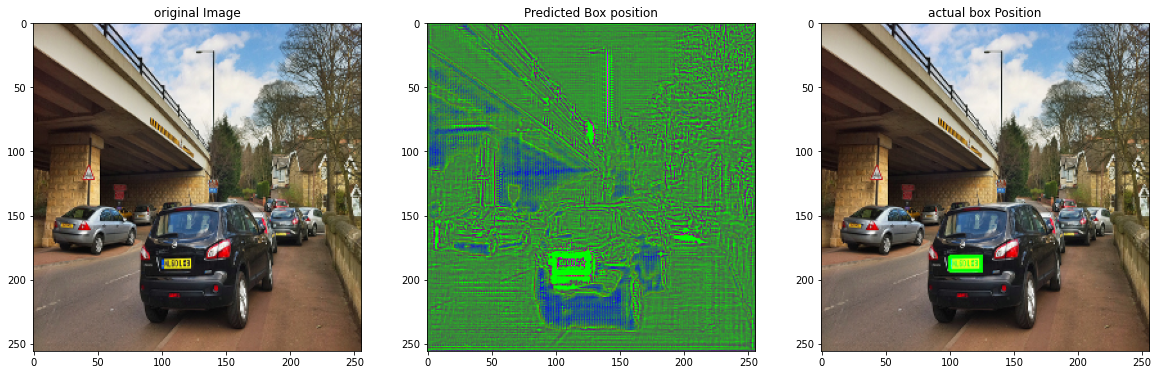

In [23]:
i = 3
Plotter(actuals[i], sixteenPrediction[i], masks[i])

Fin del código

**

**

In [18]:
# def predicx (model, shape = 256):
  #predictions = model.predict(img_new)
  #return predictions, img_new

 #def Plotter(img_new, predMask):
   # plt.figure(figsize=(20,10))
    
    #plt.subplot(1,3,1)
    #plt.imshow(img_new)
    #plt.title('original Image')
    
    ## Paso de nitidez de la imagen
    ## es un filtro de afilado
    #filter = np.array([[-1, -1, -1], [-1, 8.99, -1], [-1, -1, -1]]) 
    #imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    #plt.subplot(1,3,2)
    #plt.imshow(imgSharpen)
    #plt.title('Predicted Box position')
    


In [19]:
#sixteenPrediction = predicx(img_new)

In [20]:
#Plotter(img_new, sixteenPrediction[16])

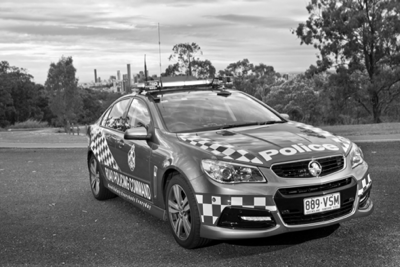

In [21]:
from google.colab.patches import cv2_imshow
img_new = cv2.imread('/gdrive/My Drive/Colab Notebooks/archive/Base de datos Placas vehículares/Cars400.png',0)
cv2_imshow(img_new)
